## Bibliotecas

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from statsmodels.iolib.summary2 import summary_col
import warnings
warnings.filterwarnings('ignore')

## Introdução

O objetivo deste estudo foi aplicar o modelo de regressão poisson que é indicado para dados de contagem que são dados positivas e diferentes de zero, por exemplo, o número de processos em uma comarca ou de pares de sapatos vendidos. Neste estudo aplicamos este modelo para analisar as variáveis macroeconômicas (var. independentes) que estão relacionadas ao número de IPOs (var. dependente) em um dado ano, o termo IPO refere-se a *initial public offering* que trata-se da primeira vez que um empresa coloca ações em negociação no mercado e foi inclusive o tema do meu TCC na graduação em Economia, porém infelizmente na época não conhecia a regressão poisson e a OLS não era apropriada. 

A hipótese que tenho com base na literatura financeira é que isso dependeria do custo do capital onde a taxa de juros seria o principal dado, expectativas para a economia que poderia ser capturado pelo desempenho do PIB e do Ibovespa e do risco que trouxe a volatilidade do Ibovespa, do índice EMBI + Brasil (diferencial de juros do Brasil vs. EUA) e da variação da taxa de câmbio.

## Base de Dados

A base de dados foi obtida a partir do Ipeadata e organizada em uma única planilha do excel que compreende o período de 2004 à 2021, já os dados do Ibovespa foram extraídos do yahoo finance. Na primeira coluna temos o número de IPOs e nas seguintes colunas temos as seguintes variáveis: 

- SELIC: Média da Taxa Selic Over (a.a) (%);
- VOL: Volatilidade diária média do índice Ibovespa; 
- PIB: Variação real do PIB (%);
- EMBI: Índice EMBI+ Brasil (proxy  de risco-brasil) (%);
- USDBRL: Variação da taxa de câmbio anual (%);
- IBOV: Variação anual do Ibovespa (%).

In [2]:
df = pd.read_excel(r'C:\Users\emanu\OneDrive\Área de Trabalho\IPO.xlsx')
df = df.set_index('Ano')
df['EMBI'] = df['EMBI']/100
df

,IPO,SELIC,VOL,PIB,EMBI,USDBRL
Ano,,,,,,
2004,7,16.2463,1.7288,5.76,3.82,-8.1291
2005,8,19.1325,1.5465,3.20,3.11,-11.8217
2006,26,15.2804,1.4691,3.96,1.92,-8.6628
2007,64,11.9762,1.6493,6.07,2.21,-17.1580
2008,4,12.3671,2.8868,5.09,4.28,31.9514
2009,6,10.0159,1.9534,-0.13,1.92,-25.5030
2010,11,9.8211,1.2466,7.53,1.89,-4.3094
2011,11,11.6678,1.4368,3.97,2.23,12.5916
2012,3,8.5431,1.3423,1.92,1.42,8.9489


In [3]:
import yfinance as yf

# Preferi extrair do yfinance do que pegar no ipeadata devido a formato
ibov = yf.download('^BVSP', period = 'max', progress=False)['Adj Close'].resample('Y').last()
ibov

Date
1993-12-31       375.500000
1994-12-31      4353.899902
1995-12-31      4299.000000
1996-12-31      7039.899902
1997-12-31     10197.000000
1998-12-31      6784.000000
1999-12-31     17092.000000
2000-12-31     15259.000000
2001-12-31     13578.000000
2002-12-31     11268.000000
2003-12-31     22236.000000
2004-12-31     26196.000000
2005-12-31     33456.000000
2006-12-31     44474.000000
2007-12-31     63886.000000
2008-12-31     37550.000000
2009-12-31     68588.000000
2010-12-31     69305.000000
2011-12-31     56754.000000
2012-12-31     60952.000000
2013-12-31     51507.000000
2014-12-31     50007.000000
2015-12-31     43350.000000
2016-12-31     60227.000000
2017-12-31     76402.000000
2018-12-31     87887.000000
2019-12-31    115964.000000
2020-12-31    119306.000000
2021-12-31    104822.000000
2022-12-31    110031.000000
2023-12-31    134185.000000
2024-12-31    131792.000000
Freq: A-DEC, Name: Adj Close, dtype: float64

In [4]:
r_ibov = ibov/ibov.shift(1)-1
r_ibov = round(r_ibov[(r_ibov.index >= '2004-12-31') & (r_ibov.index <= '2021-12-31')],4)*100
r_ibov.index = df.index
df['IBOV'] = r_ibov
df

,IPO,SELIC,VOL,PIB,EMBI,USDBRL,IBOV
Ano,,,,,,,
2004,7,16.2463,1.7288,5.76,3.82,-8.1291,17.81
2005,8,19.1325,1.5465,3.20,3.11,-11.8217,27.71
2006,26,15.2804,1.4691,3.96,1.92,-8.6628,32.93
2007,64,11.9762,1.6493,6.07,2.21,-17.1580,43.65
2008,4,12.3671,2.8868,5.09,4.28,31.9514,-41.22
2009,6,10.0159,1.9534,-0.13,1.92,-25.5030,82.66
2010,11,9.8211,1.2466,7.53,1.89,-4.3094,1.05
2011,11,11.6678,1.4368,3.97,2.23,12.5916,-18.11
2012,3,8.5431,1.3423,1.92,1.42,8.9489,7.40


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18 entries, 2004 to 2021
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IPO     18 non-null     int64  
 1   SELIC   18 non-null     float64
 2   VOL     18 non-null     float64
 3   PIB     18 non-null     float64
 4   EMBI    18 non-null     float64
 5   USDBRL  18 non-null     float64
 6   IBOV    18 non-null     float64
dtypes: float64(6), int64(1)
memory usage: 1.1 KB


In [6]:
df.describe()

,IPO,SELIC,VOL,PIB,EMBI,USDBRL,IBOV
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,13.611111,10.624994,1.566039,2.213889,2.738889,5.299939,12.537222
std,17.133177,4.214007,0.427627,3.274501,0.956580,18.911204,28.928235
min,1.000000,2.769000,1.132100,-3.550000,1.420000,-25.503000,-41.220000
25%,3.250000,8.276925,1.307875,0.680000,2.157500,-8.529375,-9.832500
50%,7.500000,10.461900,1.469300,2.465000,2.495000,5.705200,11.215000
75%,11.000000,13.127675,1.639150,4.562500,3.222500,14.328325,30.890000
max,64.000000,19.132500,2.886800,7.530000,5.230000,47.017600,82.660000


### Box plots 

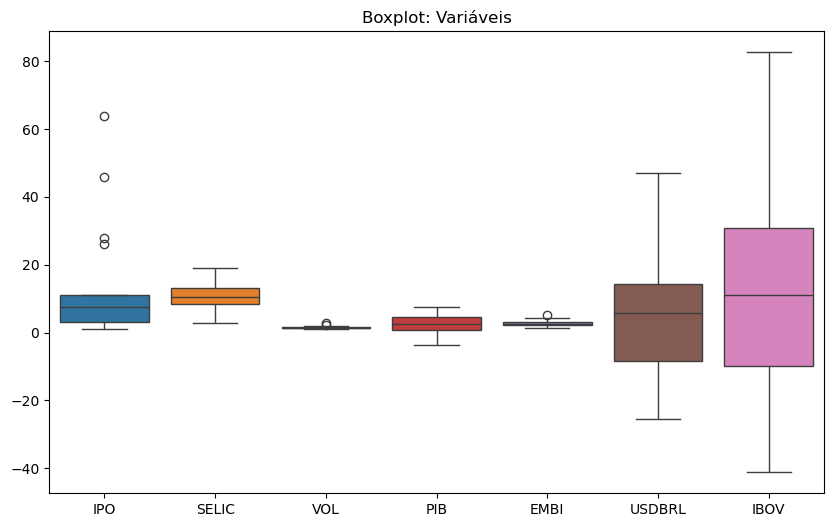

In [7]:
plt.figure(figsize=(10, 6))
sns.boxplot(df)
plt.title('Boxplot: Variáveis')
plt.show()

### Heatmap

<Axes: >

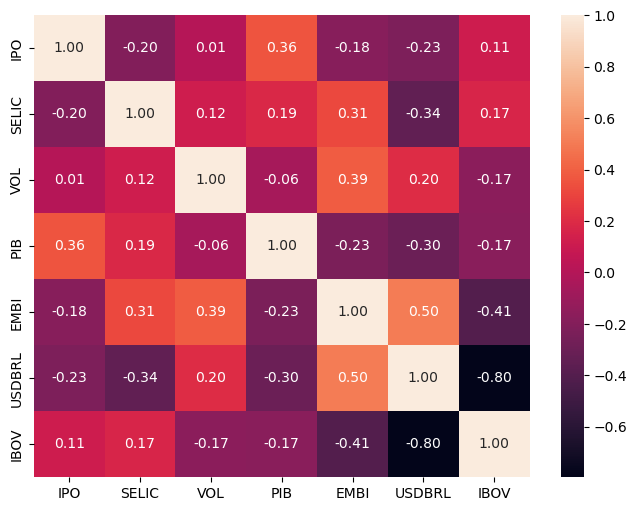

In [8]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, fmt=".2f", annot_kws={'size': 10})

### Gráfico: Desempenho Histórico das Variáveis

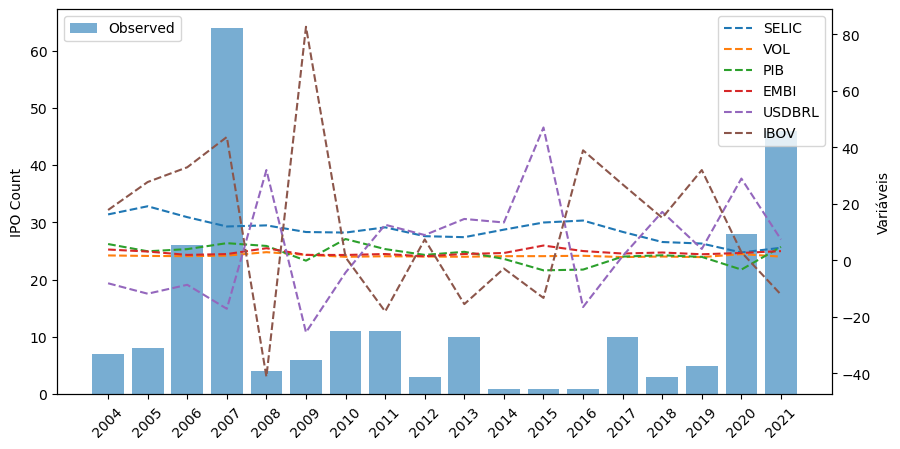

In [9]:
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.bar(df.index, df['IPO'], label='Observed', alpha=0.6)

ax2 = ax1.twinx()  

ax2.plot(df.index, df.iloc[:, 1:], label=df.iloc[:, 1:].columns, linestyle='--')

ax1.set_ylabel('IPO Count')
ax2.set_ylabel('Variáveis')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax1.set_xticks(np.arange(df.index[0], df.index[-1] + 1, 1))
ax1.set_xticklabels(np.arange(df.index[0], df.index[-1] + 1, 1), rotation=45)

plt.show()

### Distribuição dos IPOs

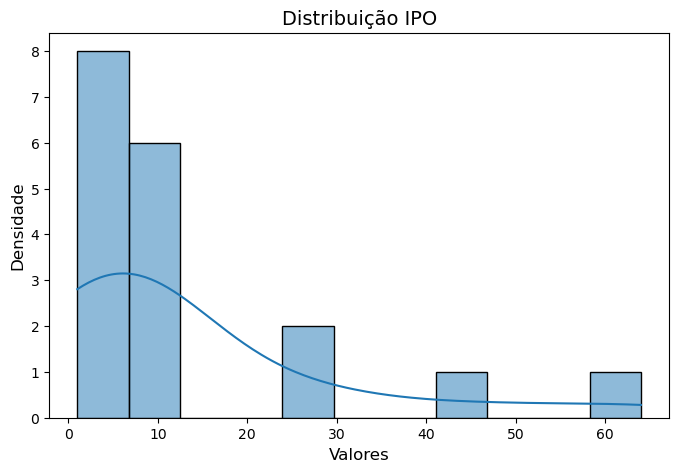

In [10]:
plt.figure(figsize=(8, 5))

sns.histplot(df['IPO'], kde=True)

plt.title('Distribuição IPO', fontsize=14)

plt.xlabel('Valores', fontsize=12)
plt.ylabel('Densidade', fontsize=12)

plt.show()

## Modelo de Regressão Poisson

Os modelos de regressão poisson são utilizados quando a variável dependente é discreta assumindo valores naturais e positivos, por exemplo, o número de camisetas no inventário de uma loja. Como o próprio nome sugere, esta variável segue uma distribuição poisson no seguinte formato: 

$$ P(X = k) = \frac{\lambda^k e^{-\lambda}}{k!} $$

onde:

- $ \lambda $ é o parâmetro de taxa (média de ocorrências),
- $ k $ é o número de ocorrências,
- $ e $ é o número de Euler,
- $ k! $ é o fatorial de $ k $.

Podemos modelar a função do nosso parâmetro de interesse $ \lambda $ como sendo igual a:

$$
\ln(\lambda) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_n X_n
$$

ou

$$
\lambda = e^{(\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_n X_n)}
$$

A estimação do modelo é feito por máxima verossimilhança (*maximum likelihood*), como o próprio nome sugere este método busca encontrar os parâmetros ($\beta$) que maximizem a probabilidade (*likelihood*) de obter a amostra observada. No caso, como trata-se de dados que seguem uma distribuição poisson podemos representar uma função de verossimilhança como:
 
$$
L = \prod_{i=1}^{n} \frac{\lambda^k e^{-\lambda}}{k!}
$$

O problema de optimização é maximizar a função *log-likelihood* que é o logarítmo natural da função de verossimilhança. 

$$
LL = \sum_{i=1}^{n} \left( - \lambda_i + Y_i \ln(\lambda_i)  - \ln(Y_i!) \right)
$$

Um vídeo que gostei sobre o assunto: https://www.youtube.com/watch?v=66FqSpf1trA

In [11]:
# Variáveis independentes
df.columns[1:]

Index(['SELIC', 'VOL', 'PIB', 'EMBI', 'USDBRL', 'IBOV'], dtype='object')

In [12]:
# Modelo com todas as variáveis 
modelo = smf.glm(formula='IPO ~ SELIC + VOL + PIB + EMBI + USDBRL + IBOV',
                 data=df,
                 family=sm.families.Poisson()).fit()

modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    IPO   No. Observations:                   18
Model:                            GLM   Df Residuals:                       11
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -110.24
Date:                Sat, 05 Oct 2024   Deviance:                       151.59
Time:                        19:36:20   Pearson chi2:                     155.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9993
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5176      0.390      6.458      0.000       1.753       3.282
SELIC         -0.1696      0.022     -7.539      0.000      -0.214      -0.125
VOL            0.6978      0.198      3.526      0.000       0.310       1.086
PIB            0.2143      0.041      5.191      0.000       0.133       0.295
EMBI           0.0089      0.119      0.075      0.940      -0.225       0.243
USDBRL        -0.0206      0.014     -1.519      0.129      -0.047       0.006
IBOV           0.0060      0.007      0.834      0.404      -0.008       0.020
==============================================================================
"""

In [13]:
# Modelo com variáveis significantes (α = 5%)
modelo = smf.glm(formula='IPO ~ SELIC + VOL + PIB + USDBRL',
                 data=df,
                 family=sm.families.Poisson()).fit()

modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    IPO   No. Observations:                   18
Model:                            GLM   Df Residuals:                       13
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -110.61
Date:                Sat, 05 Oct 2024   Deviance:                       152.32
Time:                        19:36:20   Pearson chi2:                     158.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9992
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6898      0.281      9.559      0.000       2.138       3.241
SELIC         -0.1718      0.022     -7.827      0.000      -0.215      -0.129
VOL            0.7438      0.172      4.322      0.000       0.406       1.081
PIB            0.1863      0.024      7.831      0.000       0.140       0.233
USDBRL        -0.0314      0.005     -6.754      0.000      -0.041      -0.022
==============================================================================
"""

## Superdispersão

Uma das propriedades da distribuição poisson é que a variância e a média são iguais, isso é uma hipótese importante a ser testada pois caso violado o nosso modelo pode acabar gerando parâmetros viesados (mesmo que sejam estatisticamente significativos), esse problema é chamado de superdispersão. Como vemos abaixo, a nossa amostra de dados indica a existência de superdispersão.  

In [14]:
print('Média:', round(df['IPO'].mean(),2))
print('Variância:', round(df['IPO'].var(),2))

Média: 13.61
Variância: 293.55


Segundo Favero, um método desenvolvido por Cameron e Trivedi é rodar uma regressão entre os valores previstos (fitted values) pelo modelo poisson estimado e pelo Y* que é calculado segundo a fórmula abaixo: 

$${Y_i}^* = \frac{[(Y_i - \lambda_i)^2 - Y_i]}{\lambda_i}$$ 

Rodar a regressão e verificar se o $\beta$ é superior a 5%, caso seja há equidispersão, caso contrário há superdispersão. 

$$\hat{Y_i}^* = \beta . \lambda_i$$

In [15]:
df['lambda_poisson'] = modelo.fittedvalues

df['ystar'] = (((df['IPO'] - df['lambda_poisson'])**2) - df['IPO']) / df['lambda_poisson']

modelo_auxiliar = sm.OLS.from_formula('ystar ~ 0 + lambda_poisson', df).fit()

modelo_auxiliar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  ystar   R-squared (uncentered):                   0.433
Model:                            OLS   Adj. R-squared (uncentered):              0.400
Method:                 Least Squares   F-statistic:                              13.00
Date:                Sat, 05 Oct 2024   Prob (F-statistic):                     0.00219
Time:                        19:36:20   Log-Likelihood:                         -66.032
No. Observations:                  18   AIC:                                      134.1
Df Residuals:                      17   BIC:                                      135.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
lambda_poisson     0.4869      0.135      3.605      0.002       0.202       0.772
==============================================================================
Omnibus:                       13.115   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               10.479
Skew:                           1.526   Prob(JB):                      0.00530
Kurtosis:                       5.159   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
# Validando com a função overdisp
from statstests.tests import overdisp

overdisp(modelo, df)

Estimating model...: 
 GLM
                       Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.400   
Dependent Variable:     ystar            AIC:                         134.0642
Date:                   2024-10-05 19:36 BIC:                         134.9546
No. Observations:       18               Log-Likelihood:              -66.032 
Df Model:               1                F-statistic:                 13.00   
Df Residuals:           17               Prob (F-statistic):          0.00219 
R-squared (uncentered): 0.433            Scale:                       95.219  
-----------------------------------------------------------------------------------
               Coef.       Std.Err.        t         P>|t|       [0.025      0.975]
-----------------------------------------------------------------------------------
lmbda          0.4869        0.1351      3.6049      0.0022      0.2020      0.7719
-----------------------------

## Modelo Binomial Negativo (Poisson Gama)

Indicado quando há indício de superdispersão, segue uma distribuição Poisson-Gama. 

$$ P(X = k) = \frac{\delta^\psi . v_i^{\psi-1} e^{-v_i . \delta}}{\Gamma (\psi)} $$

Onde: 

- $\delta$ = Parâmetro de forma
- $\psi$ = Parâmetro de decaimento (taxa)

Um parâmetro importante é o $\phi$ que é igual a $\frac{1}{\delta}$, este $\phi$ será utilizado no modelo do statamodels como o parâmetro (alpha = i). O objetivo é encontrar o $\phi$ que maximize o log-likelihood do modelo, ou seja, estamos diante de um problema de optimização e uma solução é rodar várias modelos com diferentes $\phi$. 

In [17]:
alphas = np.linspace(0.01, 10, 100)

# log-likelihood
llf = []

# Loop que calcula o llf para cada valor de alpha no modelo
for i in alphas: 
    model = smf.glm(formula='IPO ~ SELIC + VOL + PIB + USDBRL',
                    data=df,
                    family=sm.families.NegativeBinomial(alpha=i)).fit()
    llf.append(model.llf)

In [18]:
phi = pd.DataFrame()

phi['llf'] = llf
phi['alphas'] = alphas

phi

,llf,alphas
0,-100.513093,0.010000
1,-70.831251,0.110909
2,-64.211176,0.211818
3,-61.673198,0.312727
4,-60.586657,0.413636
...,...,...
95,-81.856172,9.596364
96,-81.998472,9.697273
97,-82.139596,9.798182
98,-82.279563,9.899091


In [19]:
# phi associado
phi_otimo = phi['alphas'].iloc[np.nanargmax(phi['llf'])]
phi_otimo

0.6154545454545455

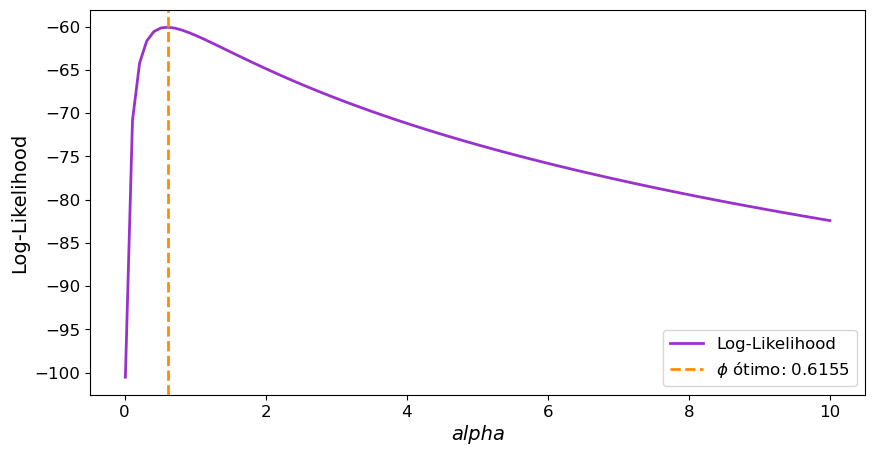

In [20]:
plt.figure(figsize=(10, 5))

plt.plot(phi['alphas'], phi['llf'], label='Log-Likelihood', color='darkorchid', linewidth = 2)

plt.axvline(x=phi_otimo, color='darkorange', linewidth = 2, linestyle='dashed',
            label=f'$\phi$ ótimo: {round(phi_otimo, 4)}')

plt.xlabel('alpha', fontsize=14, style='italic')
plt.ylabel('Log-Likelihood', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(loc='lower right', fontsize=12)

plt.show()

### Modelo Binomial Negativo - Final

Dado que encontramos o phi ótimo, podemos rodar o modelo binomial negativo.

In [21]:
# Modelo com todas as variáveis 
modelo_bneg = smf.glm(formula='IPO ~ SELIC + VOL + PIB + EMBI + USDBRL + IBOV',
                      data=df,
                      family=sm.families.NegativeBinomial(alpha=phi_otimo)).fit()

modelo_bneg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    IPO   No. Observations:                   18
Model:                            GLM   Df Residuals:                       11
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -59.781
Date:                Sat, 05 Oct 2024   Deviance:                       17.266
Time:                        19:36:26   Pearson chi2:                     15.0
No. Iterations:                    37   Pseudo R-squ. (CS):             0.5600
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4322      1.126      2.161      0.031       0.226       4.638
SELIC         -0.1376      0.068     -2.028      0.043      -0.271      -0.005
VOL            0.7366      0.545      1.352      0.176      -0.331       1.804
PIB            0.2233      0.103      2.162      0.031       0.021       0.426
EMBI          -0.1557      0.343     -0.454      0.650      -0.828       0.516
USDBRL        -0.0047      0.034     -0.139      0.890      -0.071       0.062
IBOV           0.0106      0.019      0.570      0.569      -0.026       0.047
==============================================================================
"""

In [22]:
# Modelo com variáveis significantes (α = 5%)
modelo_bneg = smf.glm(formula='IPO ~ SELIC + PIB',
                      data=df,
                      family=sm.families.NegativeBinomial(alpha=phi_otimo)).fit()

modelo_bneg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    IPO   No. Observations:                   18
Model:                            GLM   Df Residuals:                       15
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -61.956
Date:                Sat, 05 Oct 2024   Deviance:                       21.617
Time:                        19:36:26   Pearson chi2:                     24.3
No. Iterations:                    16   Pseudo R-squ. (CS):             0.4397
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1451      0.553      5.684      0.000       2.061       4.230
SELIC         -0.1121      0.051     -2.208      0.027      -0.212      -0.013
PIB            0.2041      0.067      3.030      0.002       0.072       0.336
==============================================================================
"""

## Comparação Poisson e Binomial Negativo

In [23]:
summary_col([modelo, modelo_bneg], 
            model_names=["Poisson","BNeg"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf)
            })

,Poisson,BNeg
Intercept,2.6898***,3.1451***
,(0.2814),(0.5533)
SELIC,-0.1718***,-0.1121**
,(0.0219),(0.0508)
VOL,0.7438***,
,(0.1721),
PIB,0.1863***,0.2041***
,(0.0238),(0.0674)
USDBRL,-0.0314***,
,(0.0047),


Abaixo fazemos um teste $\chi^2$ para verificar se os modelos poisson e binomial negativo são estatisticamente diferentes: 

In [24]:
llk_p = modelo.llf
llk_bneg = modelo_bneg.llf

LR_statistic = -2*(llk_p-llk_bneg)
p_val = stats.chi2.sf(LR_statistic, 1)

print('Likelihood Ratio (LR):', LR_statistic)
print('p-valor:', p_val)

Likelihood Ratio (LR): 97.30250893036245
p-valor: 5.95048823670315e-23


In [25]:
param = modelo_bneg.params
param

Intercept    3.145073
SELIC       -0.112138
PIB          0.204071
dtype: float64

In [26]:
# Previsão
print('SELIC:', df['SELIC'].iloc[0])
print('PIB:', df['PIB'].iloc[0])
print('IPO estimado:', np.exp(param[0] + param[1]*df['SELIC'].iloc[0] + param[2]*df['PIB'].iloc[0]))

SELIC: 16.2463
PIB: 5.76
IPO estimado: 12.166622199414169


In [27]:
# Validação
modelo_bneg.fittedvalues.iloc[0]

12.166622199414164

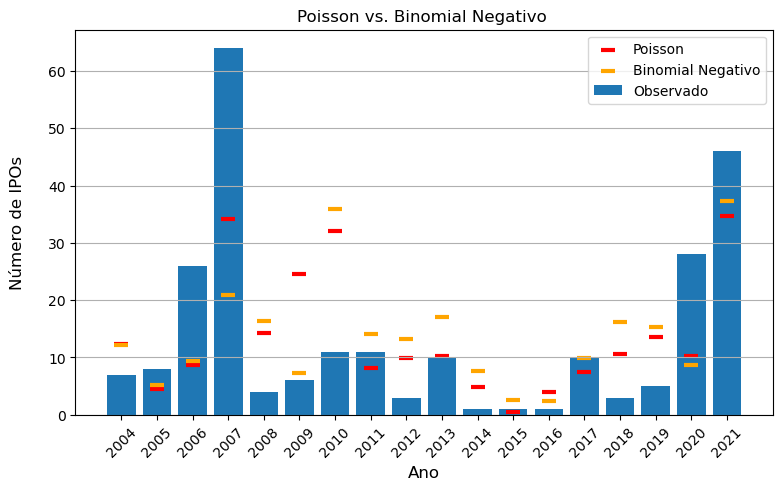

In [28]:
y = df['IPO']
y_poisson = modelo.fittedvalues
Y_bneg = modelo_bneg.fittedvalues

plt.figure(figsize=(9,5))

plt.title('Poisson vs. Binomial Negativo ')

plt.bar(df.index, y, label = 'Observado')
plt.scatter(df.index, y_poisson, label = 'Poisson', color = 'red', marker='_', s= 100, linewidths=3)
plt.scatter(df.index, Y_bneg, label = 'Binomial Negativo', color = 'orange', marker='_', s= 100, linewidths=3)

plt.xticks(np.arange(df.index[0], df.index[-1] + 1, 1), rotation=45)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Número de IPOs\n', fontsize=12)

plt.legend()

plt.grid(axis='y')
plt.show()

## Conclusão

A nossa variável dependente (IPO) indica a presença de superdispersão o que nos leva a precisar trabalhar com o modelo binomial negativo (bneg) visto que não podemos assumir que segue uma distribuição poisson (média e variância diferentes), pelo critério de significância estatística ($\alpha$ > 5%) os modelos acabaram tendo variáveis independentes diferentes. No modelo binomial negativo acabamos ficando com a taxa SELIC e o PIB como as variáveis significativas para explicar o número de IPOs, a função de regressão estimada é a seguinte: 

$IPO = e^{\,(\,3.1450 \,-\, 0.1121 \,\cdot\, SELIC \,+\, 0.2040 \,\cdot\, PIB\,)}$ 

O resultado é razoável se pensarmos nas razões pelo qual uma empresa busca abrir capital que seria dentre variáveis motivos um dos principais é financiar projetos de investimento que possam sustentar o crescimento futuro da companhia que por sua vez dependente da taxa de juros (SELIC) que impacta diretamente o custo de capital e também das expectativas para a economia onde o PIB é a métrica mais conhecida. 